In [1]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'examples'))
	print(os.getcwd())
except:
	pass


In [2]:
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'examples'))
	print(os.getcwd())
except:
	pass


   # TRF Tutorial

   In this notebook we show how to import word onset as a word-level feature and compute TRF from them.

   ## Import EEG

In [3]:
import os
from scipy.io import loadmat
from pyeeg.io import eeglab2mne

subj_id = 3 # id of participant (3 is subject P04)
story_id = 1 # id of stories (1 is AUNP02)


INFO:summarizer.preprocessing.cleaner:'pattern' package found; tag filters are available for English


In [4]:
eeg_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/Processed/Fs-125/interp_bad/BP-0.3-65/Blink_pruned/'
list_subjects = os.listdir(eeg_path)
eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]

raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False)
raw.pick_types(eeg=True)
raw = raw.filter(1, 15, n_jobs=2)


The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['story_onset', 'boundary'], 2 in total
12/12 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
As is, the trigger channel will consist entirely of zeros.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:170: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:170: RuntimeWarning: Events like the following will be dropped entirely: ['story_onset', 'boundary'], 2 in total
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:170: RuntimeWarning: 12/12 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)
/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:170: Runtim

   ## Import Word-level features

In [5]:
# Import all paths
from pyeeg.io import WordLevelFeatures
env_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/story_parts/alignement_data/'
wordfreq_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment/story_parts/word_frequencies/'
list_wordfreq_files = [item for item in os.listdir(wordfreq_path) if item.endswith('timed.csv')]
list_stories = [item.strip('_word_freq_timed.csv') for item in list_wordfreq_files]
list_env_files = [os.path.join(env_path, s, s + '_125Hz.Env') for s in list_stories]

onset_path = '/home/hw2512/Workspace/EEG_work/all_katerina_onsets.mat'
onsets = loadmat(onset_path)['onsets']

# Loading word onset and duration for AUNP02:
wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
duration_path = os.path.join(env_path, list_env_files[story_id])



In [6]:
# Create word-level feature object:
wf = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path)
x = wf.align_word_features(srate=raw.info['sfreq'], features=[])
y = raw.get_data()
indices = wf.samples_from_onset(onsets[subj_id, story_id], srate=raw.info['sfreq'])
y = y[:, indices].T


   ## Run TRF modelling
 The TRFEstimator class allows to use any arbitrary set of lags. The lagged time series design matrix
 will be generated when fitting the class instance to aligned EEG and feature data.

In [7]:
from pyeeg.models import TRFEstimator
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'])
trf.fit(x, y, feat_names=["Word Onsets"])


INFO:pyeeg.models:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/hw2512/anaconda/envs/EEG/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/hw2512/anaconda/envs/EEG/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


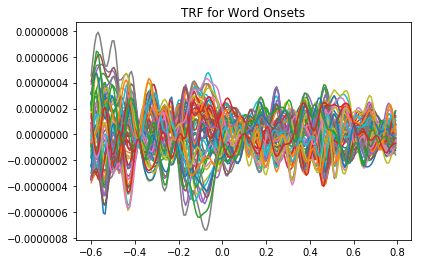

In [8]:
# Plot model:
trf.plot_single_feature(0)
